In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('../../data/Accidentes_2013_2023.csv')

# Reemplazar los NaN en 'fall_les' con la categoría 'Ignorado'
df['fall_les'] = df['fall_les'].fillna('Ignorado')

# Confirmar la nueva distribución de clases en la variable objetivo
fall_les_distribution = df['fall_les'].value_counts(dropna=False)
print("\nDistribución de clases en 'fall_les' después de la limpieza:\n", fall_les_distribution)


Distribución de clases en 'fall_les' después de la limpieza:
 fall_les
Lesionado    64038
Ignorado     22566
Fallecido    12911
Name: count, dtype: int64


# Modelo de Regresión Lineal

In [3]:
# Separar X e y
X = df.drop(columns=['fall_les'])
y = df['fall_les']

# One-hot encoding de variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Codificar clase objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)


Matriz de Confusión:
 [[  654     3  3216]
 [    1  6768     1]
 [   88     5 19119]]

Informe de Clasificación:
               precision    recall  f1-score   support

   Fallecido       0.88      0.17      0.28      3873
    Ignorado       1.00      1.00      1.00      6770
   Lesionado       0.86      1.00      0.92     19212

    accuracy                           0.89     29855
   macro avg       0.91      0.72      0.73     29855
weighted avg       0.89      0.89      0.86     29855


Exactitud del modelo: 88.90%


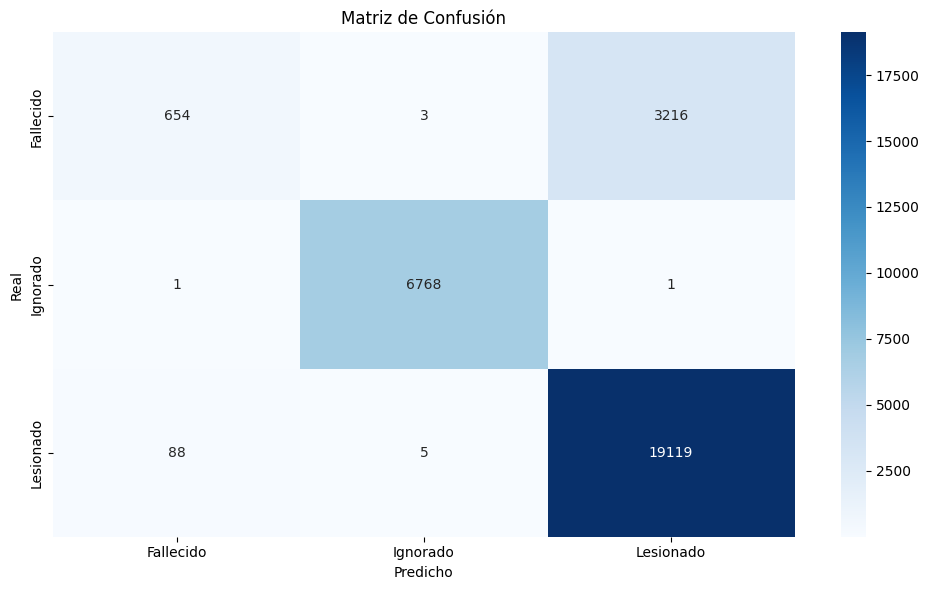

In [4]:
# Entrenar el modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = log_reg.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_matrix)

# Informe de clasificación
print("\nInforme de Clasificación:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print("\nExactitud del modelo: {:.2f}%".format(accuracy * 100))

# Visualizar matriz de confusión
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


# Mejor modelo RL 

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Definir el modelo base
logreg = LogisticRegression(max_iter=1000, solver='liblinear')  # 'liblinear' soporta l1 y l2

# Definir grilla de hiperparámetros
param_grid = {
    'penalty': ['l2'],  # elimina 'l1' si no es esencial
    'C': [0.1, 1, 10],  # reduce cantidad de C
    'class_weight': ['balanced']  # si ya sabés que mejora rendimiento
}

# GridSearchCV con validación cruzada estratificada
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:\n", grid.best_params_)


Mejores hiperparámetros encontrados:
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}


# Evluando mejor RL


Informe de Clasificación:
               precision    recall  f1-score   support

   Fallecido       0.51      0.37      0.43      3873
    Ignorado       1.00      1.00      1.00      6770
   Lesionado       0.88      0.93      0.90     19212

    accuracy                           0.87     29855
   macro avg       0.80      0.77      0.78     29855
weighted avg       0.86      0.87      0.86     29855

Exactitud del modelo: 87.28%


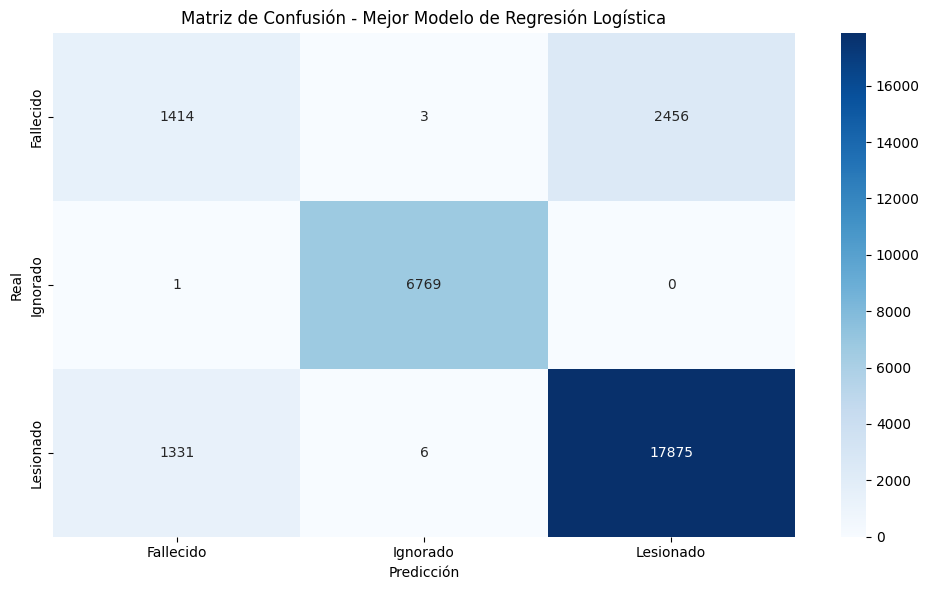

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Usar el mejor modelo encontrado por GridSearchCV
best_model = grid.best_estimator_

# Predicciones sobre el conjunto de prueba
y_pred = best_model.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Reporte de clasificación
print("\nInforme de Clasificación:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del modelo: {:.2f}%".format(accuracy * 100))

# Visualización con seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - Mejor Modelo de Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


- El modelo hiperparametrizado sacrificó un poco de precisión global (accuracy) pero mejoró mucho en la clase "Fallecido", que es típicamente la más importante por ser crítica aunque poco frecuente.
- La caída en precisión para "Fallecido" es esperable al balancear clases, pero se compensa con un gran aumento en recall, que es crucial si lo que importa es detectar fallecidos aunque haya más falsos positivos.

## ¿Qué modelo elegir?

- Si detectar fallecidos es prioritario → usa el modelo con hiperparámetros.
- Si accuracy general es lo más importante → el modelo normal tiene una leve ventaja.
- En la mayoría de los casos reales, mejorar recall de la clase minoritaria crítica (fallecidos) es más valioso que tener una accuracy ligeramente mayor.


